# Logistic Regression Model

## Data Import And Cleaning

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from functools import partial

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = ['../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0
#the operation to be used for math operations during training.
math_operation = partial(np.square)

In [4]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [5]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [6]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000


In [7]:
train_dfs[train_index][[target_column]].describe()

,BGA-Phycocyanin RFU
count,18947.000000
mean,0.979511
std,0.731423
min,0.000000
25%,0.500000
50%,0.900000
75%,1.200000
max,16.100000


In [8]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000
mean,19.131184,1990.294607,-196.624329,8.922357,63.929067,90.057202,8.309566,1.459773
std,5.045367,230.743946,27.769024,0.357733,70.885989,17.627283,1.486747,1.311960
min,0.000000,0.000000,-284.000000,0.000000,-0.880000,0.000000,0.000000,-0.400000
25%,15.480000,1869.000000,-216.950000,8.730000,33.750000,79.100000,7.280000,0.600000
50%,20.190000,1958.000000,-192.000000,8.920000,48.380000,85.300000,8.010000,1.000000
75%,23.070000,2149.000000,-179.500000,9.100000,68.275000,95.300000,9.240000,1.700000
max,28.600000,2417.000000,0.000000,10.100000,1248.920000,245.500000,19.590000,21.100000


## Use Datetime Index

In [9]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [10]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [11]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Fill missing values


In [12]:
# Fill all missing values with the mean
for df in test_dfs + train_dfs:
    for column in df.columns:
        number_null = np.sum(df[column].isnull())
        column_length = len(df[column])
        print('{} percent null: {:.1f}%'.format(
            column, (number_null / column_length) * 100))
        if number_null > 0:
            print("Filling {} with mean: {}\n".format(column, df[column].mean()))
            df[column] = df[column].fillna(df[column].mean()) 

Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 3.2%
Filling Turbidity (NTU) with mean: 64.9625066543

## Add Weather Data

In [13]:
## Import And Clean Weather Data
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')

# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
print(weather.dtypes)

weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']
DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object


In [14]:
# Add the weather data to our training/testing sets
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for d in df['datetime']:
            d = d.date()
            if d != old_datetime:
                old_datetime = d
                value = weather[weather['DATE'] == d][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Adding the Wind to weather


In [15]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))

In [16]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [17]:
#we need to join the wind data now to the existing dataframes, but the dont care about

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [18]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

## Extract Windows


In [19]:
presegmented_plot = pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     'Bloom Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)})

# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i)
    train_dfs[i] = hf.data_window_reduction(
        train_dfs[i], 'datetime', target_column)
    print("Windowizing 2018 data set:", i)
    test_dfs[i] = hf.data_window_reduction(
        test_dfs[i], 'datetime', target_column)
    print()

Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



## Add Weather Categories

In [20]:
# Add a rainy category
for df in test_dfs + train_dfs:
    df['rained'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')
test_dfs[test_index].columns

# add the weather columns to our x_columns
x_columns = list(set(x_columns 
                     + ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'rained', 'Wind Speed', 'Wind Angle']))

## Add Time of day Category

In [21]:
for df in train_dfs + test_dfs:
        df['time of day'] = df['datetime'].apply(hf.create_time_of_day).astype('category')
x_columns.append('time of day')
train_dfs[train_index].head()

,BGA-Phycocyanin RFU,ODO (mg/L),ODOSat%,PRCP,SNOW,SNWD,Sp Cond (uS/cm),TMAX,TMIN,Temp C,Turbidity (NTU),Wind Angle,Wind Speed,datetime,pH,pH (mV),rained,time of day
datetimeIndex,,,,,,,,,,,,,,,,,,
2017-05-08 07:48:00,0.6,9.464,95.66,1.8,0.0,0.0,1939.0,31.7,18.9,17.308,97.160,328.0,112.00,2017-05-08 07:48:00,8.39,-99.20,1,morning
2017-05-08 21:48:00,0.7,9.464,95.66,1.8,0.0,0.0,1953.0,31.7,18.9,17.532,97.276,325.5,112.00,2017-05-08 21:48:00,8.39,-99.20,1,evening
2017-05-09 11:48:00,0.7,8.852,90.70,1.8,0.0,0.0,1953.0,30.6,18.9,17.914,97.276,330.0,112.00,2017-05-09 11:48:00,8.38,-99.20,1,afternoon
2017-05-10 01:48:00,0.5,8.534,88.42,1.8,0.0,0.0,1953.0,30.6,18.9,18.330,100.720,330.0,112.00,2017-05-10 01:48:00,8.38,-99.20,1,night
2017-05-10 15:48:00,0.5,8.304,87.02,0.0,0.0,0.0,1953.0,27.2,18.9,18.820,97.324,330.0,89.25,2017-05-10 15:48:00,8.38,-99.58,0,dusk


## Add Derivatives

In [37]:
# The derivative is the rate of change.
a = train_dfs[0]['Temp C'].iloc[0]
b = train_dfs[0]['Temp C'].iloc[1]
print("a: {}, b: {}".format(a, b))
print("b - a:", b-a)
# we will use the numpy gradient function to find the derivatives in a series
temp_gradient = np.gradient(train_dfs[0]['Temp C'])
print(temp_gradient[0])

# check that the mathop function matches.
df = lrf.apply_math_operation(train_dfs[0][['Temp C']], np.gradient, '_gradient')
print("Series are equal:", np.array_equal(df['Temp C_gradient'], temp_gradient))
df.head(5)

a: 17.308, b: 17.532
b - a: 0.2240000000000002
0.2240000000000002
Series are equal:  True


,Temp C_gradient
datetimeIndex,
2017-05-08 07:48:00,0.224
2017-05-08 21:48:00,0.303
2017-05-09 11:48:00,0.399
2017-05-10 01:48:00,0.453
2017-05-10 15:48:00,0.245


In [38]:
for df in train_dfs + test_dfs:
    gradients = lrf.apply_math_operation(df[x_columns], np.gradient, '_gradient')
    df[gradients.columns] = gradients
x_columns = list(set(x_columns + list(gradients.columns)))
train_dfs[0].head(5)

C:\git\senior_design\pannts-ml\notebooks\models\scripts\logistic_regression_functions.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  result[col + name_addition] = op(dataframe[col])


,BGA-Phycocyanin RFU,ODO (mg/L),ODOSat%,PRCP,SNOW,SNWD,Sp Cond (uS/cm),TMAX,TMIN,Temp C,...,pH_gradient,ODO (mg/L)_gradient,PRCP_gradient,TMAX_gradient,pH (mV)_gradient,TMIN_gradient,SNWD_gradient,Wind Angle_gradient,SNOW_gradient,Sp Cond (uS/cm)_gradient
datetimeIndex,,,,,,,,,,,,,,,,,,,,,
2017-05-08 07:48:00,0.6,9.464,95.66,1.8,0.0,0.0,1939.0,31.7,18.9,17.308,...,0.000,0.000,0.0,0.00,0.00,0.00,0.0,-2.50,0.0,14.0
2017-05-08 21:48:00,0.7,9.464,95.66,1.8,0.0,0.0,1953.0,31.7,18.9,17.532,...,-0.005,-0.306,0.0,-0.55,0.00,0.00,0.0,1.00,0.0,7.0
2017-05-09 11:48:00,0.7,8.852,90.70,1.8,0.0,0.0,1953.0,30.6,18.9,17.914,...,-0.005,-0.465,0.0,-0.55,0.00,0.00,0.0,2.25,0.0,0.0
2017-05-10 01:48:00,0.5,8.534,88.42,1.8,0.0,0.0,1953.0,30.6,18.9,18.330,...,0.000,-0.274,-0.9,-1.70,-0.19,0.00,0.0,0.00,0.0,0.0
2017-05-10 15:48:00,0.5,8.304,87.02,0.0,0.0,0.0,1953.0,27.2,18.9,18.820,...,0.000,-0.157,-0.9,-1.40,-0.15,-3.35,0.0,0.00,0.0,0.0


## Logistic Regression Model
### Null Model

In [ ]:
lrf.add_target_column(train_dfs + test_dfs, threshold=RFU_THRESHOLD)

In [61]:
train = train_dfs[0]
test = test_dfs[0].append(test_dfs[1])

In [49]:
# The null model's performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train, test, x_columns, 'bloom', null_model=True)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", train_dfs[train_index].columns)

Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]
columns: Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'PRCP', 'SNOW', 'SNWD',
       'Sp Cond (uS/cm)', 'TMAX', 'TMIN', 'Temp C', 'Turbidity (NTU)',
       'Wind Angle', 'Wind Speed', 'datetime', 'pH', 'pH (mV)', 'rained',
       'time of day', 'Wind Speed_gradient', 'ODOSat%_gradient',
       'Temp C_gradient', 'Turbidity (NTU)_gradient', 'pH_gradient',
       'ODO (mg/L)_gradient', 'PRCP_gradient', 'TMAX_gradient',
       'pH (mV)_gradient', 'TMIN_gradient', 'SNWD_gradient',
       'Wind Angle_gradient', 'SNOW_gradient', 'Sp Cond (uS/cm)_gradient',
       'bloom'],
      dtype='object')


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### All variables model

In [50]:
# All variables model performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train, test, x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", x_columns)

Accuracy 0.7111436950146628
Recall: 0.5635491606714629
Precision 0.94
Confusion Matrix:
 [[250  15]
 [182 235]]
columns: ['Turbidity (NTU)_gradient', 'PRCP_gradient', 'SNOW_gradient', 'Wind Speed_gradient', 'SNWD', 'Sp Cond (uS/cm)', 'Wind Angle_gradient', 'pH_gradient', 'rained', 'ODOSat%_gradient', 'pH', 'SNWD_gradient', 'ODO (mg/L)', 'Sp Cond (uS/cm)_gradient', 'PRCP', 'TMAX', 'TMIN', 'pH (mV)_gradient', 'Wind Angle', 'Wind Speed', 'ODOSat%', 'Temp C', 'Turbidity (NTU)', 'time of day', 'pH (mV)', 'TMAX_gradient', 'TMIN_gradient', 'ODO (mg/L)_gradient', 'Temp C_gradient', 'SNOW']


### Best model to date

In [51]:
max_iter = 25000
loss = "log"
base_columns = ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train, test, base_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", base_columns)

Accuracy 0.8035190615835777
Recall: 0.7817745803357314
Precision 0.8834688346883469
Confusion Matrix:
 [[222  43]
 [ 91 326]]
columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']


### Greedy Model

In [62]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')

Training model with: Turbidity (NTU)_gradient
Accuracy 0.4149560117302053
Recall: 0.05515587529976019
Precision 0.8214285714285714
Confusion Matrix:
 [[260   5]
 [394  23]]

Training model with: PRCP_gradient
Accuracy 0.3885630498533724
Recall: 0.007194244604316547
Precision 0.5
Confusion Matrix:
 [[262   3]
 [414   3]]

Training model with: SNOW_gradient


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: Wind Speed_gradient
Accuracy 0.3914956011730205
Recall: 0.004796163069544364
Precision 1.0
Confusion Matrix:
 [[265   0]
 [415   2]]

Training model with: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: Wind Angle_gradient
Accuracy 0.39589442815249265
Recall: 0.02877697841726619
Precision 0.631578947368421
Confusion Matrix:
 [[258   7]
 [405  12]]

Training model with: pH_gradient
Accuracy 0.4633431085043988
Recall: 0.2302158273381295
Precision 0.6808510638297872
Confusion Matrix:
 [[220  45]
 [321  96]]

Training model with: rained


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: ODOSat%_gradient
Accuracy 0.4442815249266862
Recall: 0.12709832134292565
Precision 0.7794117647058824
Confusion Matrix:
 [[250  15]
 [364  53]]

Training model with: pH
Accuracy 0.7302052785923754
Recall: 0.8009592326139089
Precision 0.767816091954023
Confusion Matrix:
 [[164 101]
 [ 83 334]]

Training model with: SNWD_gradient


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: ODO (mg/L)
Accuracy 0.6656891495601173
Recall: 0.5419664268585132
Precision 0.8593155893536122
Confusion Matrix:
 [[228  37]
 [191 226]]

Training model with: Sp Cond (uS/cm)_gradient
Accuracy 0.39002932551319647
Recall: 0.004796163069544364
Precision 0.6666666666666666
Confusion Matrix:
 [[264   1]
 [415   2]]

Training model with: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: TMAX
Accuracy 0.5410557184750733
Recall: 0.4364508393285372
Precision 0.7
Confusion Matrix:
 [[187  78]
 [235 182]]

Training model with: TMIN
Accuracy 0.6847507331378299
Recall: 0.5707434052757794
Precision 0.8686131386861314
Confusion Matrix:
 [[229  36]
 [179 238]]

Training model with: pH (mV)_gradient
Accuracy 0.45454545454545453
Recall: 0.1774580335731415
Precision 0.7184466019417476
Confusion Matrix:
 [[236  29]
 [343  74]]

Training model with: Wind Angle
Accuracy 0.4912023460410557
Recall: 0.24700239808153476
Precision 0.7573529411764706
Confusion Matrix:
 [[232  33]
 [314 103]]

Training model with: Wind Speed
Accuracy 0.5146627565982405
Recall: 0.31414868105515587
Precision 0.7443181818181818
Confusion Matrix:
 [[220  45]
 [286 131]]

Training model with: ODOSat%
Accuracy 0.7067448680351907
Recall: 0.5995203836930456
Precision 0.8833922261484098
Confusion Mat

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: time of day


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: pH (mV)
Accuracy 0.6143695014662757
Recall: 1.0
Precision 0.6132352941176471
Confusion Matrix:
 [[  2 263]
 [  0 417]]

Training model with: TMAX_gradient
Accuracy 0.37683284457478006
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[257   8]
 [417   0]]

Training model with: TMIN_gradient


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: ODO (mg/L)_gradient
Accuracy 0.45454545454545453
Recall: 0.14148681055155876
Precision 0.8082191780821918
Confusion Matrix:
 [[251  14]
 [358  59]]

Training model with: Temp C_gradient


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

Training model with: SNOW
Accuracy 0.3885630498533724
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[265   0]
 [417   0]]

pH metric value: 0.7302052785923754
ODOSat% metric value: 0.7067448680351907
TMIN metric value: 0.6847507331378299
ODO (mg/L) metric value: 0.6656891495601173
pH (mV) metric value: 0.6143695014662757
Temp C metric value: 0.6041055718475073
TMAX metric value: 0.5410557184750733
Wind Speed metric value: 0.5146627565982405
Wind Angle metric value: 0.4912023460410557
pH_gradient metric value: 0.4633431085043988
pH (mV)_gradient metric value: 0.45454545454545453
ODO (mg/L)_gradient metric value: 0.45454545454545453
ODOSat%_gradient metric value: 0.4442815249266862
Turbidity (NTU)_gradient metric value: 0.4149560117302053
Wind Angle_gradient metric value: 0.39589442815249265
Wind Speed_gradient metric value: 0.3914956011730205
Sp Cond (uS/cm)_gradient metric value: 0.39002932

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train, test, x_columns, 
                                            'bloom', sorted_columns)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'pH (mV)', 'Temp C', 'TMAX', 'Wind Speed', 'Wind Angle', 'pH_gradient', 'pH (mV)_gradient', 'ODO (mg/L)_gradient', 'ODOSat%_gradient', 'Turbidity (NTU)_gradient', 'Wind Angle_gradient', 'Wind Speed_gradient', 'Sp Cond (uS/cm)_gradient', 'PRCP_gradient', 'SNOW_gradient', 'SNWD', 'Sp Cond (uS/cm)', 'rained', 'SNWD_gradient', 'PRCP', 'Turbidity (NTU)', 'time of day', 'TMIN_gradient', 'Temp C_gradient', 'SNOW', 'TMAX_gradient']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'pH (mV)', 'Temp C', 'TMAX', 'Wind Speed', 'Wind Angle', 'pH_gradient', 'pH (mV)_gradient', 'ODO (mg/L)_gradient', 'ODOSat%_gradient', 'Turbidity (NTU)_gradient', 'Wind Angle_gradient', 'Wind Speed_gradient', 'Sp Cond (uS/cm)_gradient', 'PRCP_gradient', 'SNOW_gradient', 'SNWD', 'Sp Cond (uS/cm)', 'rained', 'SNWD_gradient', 'PRCP', 'Turbidity (NTU)', 'time of day', 'TMIN_gradient', 'Temp C_gradient', 'SNOW', 'TMAX_gradient']
Traini

Model AUC: 0.8778


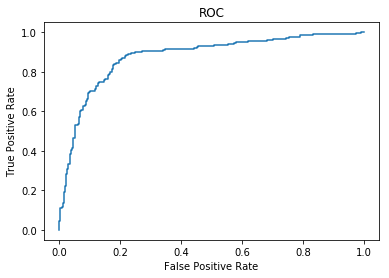

In [64]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test[['bloom']].values, predictions)

### Greedy Model With Base Columns

In [65]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train, test, x_columns, 
                                            'bloom', sorted_columns, base_columns)


base_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'ODO (mg/L)', 'pH (mV)', 'Temp C', 'TMAX', 'Wind Speed', 'Wind Angle', 'pH_gradient', 'pH (mV)_gradient', 'ODO (mg/L)_gradient', 'ODOSat%_gradient', 'Turbidity (NTU)_gradient', 'Wind Angle_gradient', 'Wind Speed_gradient', 'Sp Cond (uS/cm)_gradient', 'PRCP_gradient', 'SNOW_gradient', 'SNWD', 'Sp Cond (uS/cm)', 'rained', 'SNWD_gradient', 'PRCP', 'Turbidity (NTU)', 'time of day', 'TMIN_gradient', 'Temp C_gradient', 'SNOW', 'TMAX_gradient']
adjusted sorted_columns: ['TMIN', 'pH (mV)', 'TMAX', 'Wind Speed', 'Wind Angle', 'pH_gradient', 'pH (mV)_gradient', 'ODO (mg/L)_gradient', 'ODOSat%_gradient', 'Turbidity (NTU)_gradient', 'Wind Angle_gradient', 'Wind Speed_gradient', 'Sp Cond (uS/cm)_gradient', 'PRCP_gradient', 'SNOW_gradient', 'SNWD', 'rained', 'SNWD_gradient', 'PRCP', 'Turbidity (NTU)', 'time of day', 'TMIN_gradient', 'Temp C_gradient', 'SNOW', 'TMAX_gradient']
Training

Test model accuracy: 0.8313782991202346
Test model recall: 0.8273381294964028
Test model precision: 0.8891752577319587

Final greedy columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'TMIN', 'TMAX', 'Wind Angle', 'Turbidity (NTU)_gradient', 'Sp Cond (uS/cm)_gradient', 'PRCP_gradient', 'rained', 'Turbidity (NTU)']
Final greedy accuracy 0.8313782991202346
Final greedy recall: 0.8369304556354916
Final greedy precision: 0.8813131313131313
Final greedy confusion matrix:
 [[218  47]
 [ 68 349]]


In [67]:
# Cross validate
base_columns = ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'TMIN', 'TMAX', 'Wind Angle', 'Turbidity (NTU)_gradient', 'Sp Cond (uS/cm)_gradient', 'PRCP_gradient', 'rained', 'Turbidity (NTU)']
accuracy, recall, precision, cm, predictions, predictions_prob, mode = lrf.train_model(
    model, train, test, base_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

base_columns = ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'TMIN', 'TMAX', 'Wind Angle', 'Turbidity (NTU)_gradient', 'Sp Cond (uS/cm)_gradient', 'PRCP_gradient', 'rained', 'Turbidity (NTU)']
accuracy, recall, precision, cm, predictions, predictions_prob, mode = lrf.train_model(
    model, test, train, base_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

# Include 2017 Marina
train = train_dfs[0].append(train_dfs[1])
accuracy, recall, precision, cm, predictions, predictions_prob, mode = lrf.train_model(
    model, train, test, base_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

base_columns = ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)', 'TMIN', 'TMAX', 'Wind Angle', 'Turbidity (NTU)_gradient', 'Sp Cond (uS/cm)_gradient', 'PRCP_gradient', 'rained', 'Turbidity (NTU)']
accuracy, recall, precision, cm, predictions, predictions_prob, mode = lrf.train_model(
    model, test, train, base_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.8313782991202346
Recall: 0.8369304556354916
Precision 0.8813131313131313
Confusion Matrix:
 [[218  47]
 [ 68 349]]
Accuracy 0.7824773413897281
Recall: 0.7633587786259542
Precision 0.7092198581560284
Confusion Matrix:
 [[159  41]
 [ 31 100]]
Accuracy 0.7976539589442815
Recall: 0.8057553956834532
Precision 0.8549618320610687
Confusion Matrix:
 [[208  57]
 [ 81 336]]
Accuracy 0.7931570762052877
Recall: 0.7611336032388664
Precision 0.7175572519083969
Confusion Matrix:
 [[322  74]
 [ 59 188]]


## Random Forest Model

In [55]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train, test, x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.7771260997067448
Recall: 0.86810551558753
Precision 0.7886710239651417
Confusion Matrix:
 [[168  97]
 [ 55 362]]


Model AUC: 0.8474


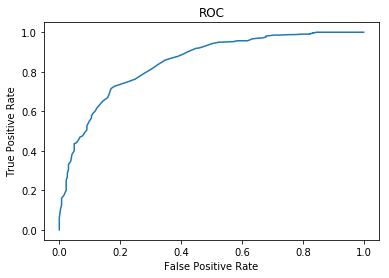

In [56]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test[['bloom']].values, predictions)

## Random Forest Model

In [58]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train, test, x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.7595307917888563
Recall: 0.8393285371702638
Precision 0.7829977628635347
Confusion Matrix:
 [[168  97]
 [ 67 350]]


Model AUC: 0.8486


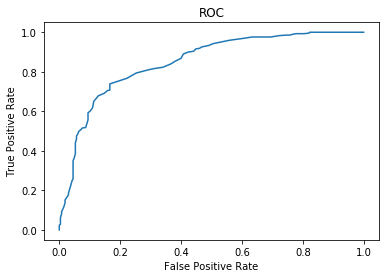

In [59]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test[['bloom']].values, predictions)